In [1]:
import sys
sys.path.append('./Tiny_Faces_in_Tensorflow/')
import tiny_face_eval as tiny
from metrics import *
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import mean_squared_error as mse
import glob
import os
import cv2
import pandas as pd
from sklearn.svm import SVC
import numpy as np
import imp
import time
import random
import detect
import dlib
from imgaug import augmenters as iaa
imp.reload(tiny)
imp.reload(detect)
%matplotlib inline

In [2]:
weights_path = './Tiny_Faces_in_Tensorflow/hr_res101.pkl'
face_encoder = dlib.face_recognition_model_v1('./model/dlib_face_recognition_resnet_model_v1.dat')
face_pose_predictor = dlib.shape_predictor('./model/shape_predictor_68_face_landmarks.dat')

1103/1088 frame

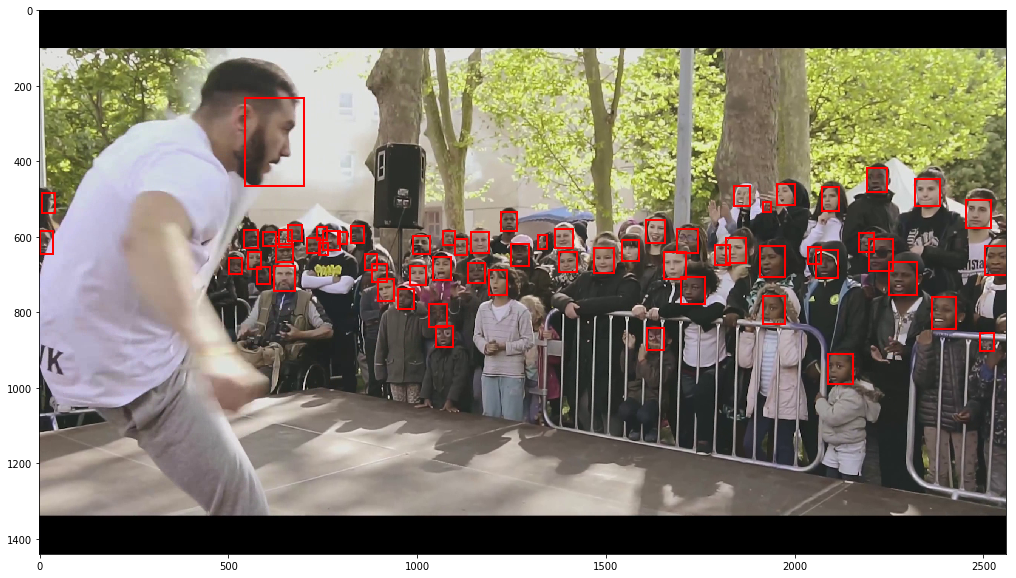

In [3]:
cap = cv2.VideoCapture()
cap.open('/home/alexattia/Work/RecVis/famvk.avi')
fps = cap.get(cv2.CAP_PROP_FPS)
target = int(45 * fps) + 10
i = 0
pics, detections = [], []
while(True):
    ret, frame = cap.read()
    i +=1 
    print('\r%s/%s frame' % (i,target), end='')
    if i in [target, target+1, target+2, target+15]:
        with tf.Graph().as_default():
            b = tiny.evaluate(weight_file_path=weights_path, data_dir='a.jpg', output_dir='', framee=frame[:,:,::-1],
                          prob_thresh=0.5, nms_thresh=0.1,
                          lw=3, display=False, save=False, draw=False, print_=0)

        if (i == target):
            f, ax = plt.subplots(figsize=(20,10))
            ax.imshow(frame[:,:,::-1])
            # plot the predicted bounding boxes
            for k in b[0]:
                x1, y1 = k[:2]
                w, h = k[2] - k[0], k[3] - k[1]
                rect = patches.Rectangle((x1,y1),w, h,linewidth=2,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
        pics.append(frame[:,:,::-1])
        detections.append(b[0])
        if (i == target+15):
            break

128

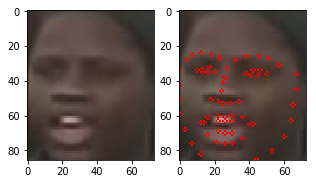

In [4]:
# We pick one face (e.g face number 14)
x1, y1, x2, y2 = detections[0][14]
f, ax = plt.subplots(ncols=2, figsize=(5,5))
img = pics[0][y1:y2,x1:x2,:]
ax[0].imshow(img)
detected_face = dlib.rectangle(left=0, top=0, right=x2-x1, bottom=y2-y1)
img1 = img.copy()
pose_landmarks = face_pose_predictor(img, detected_face)
for p in pose_landmarks.parts():
    cv2.circle(img1, (p.x, p.y), 1, (255,0,0))
ax[1].imshow(img1)

face_encoding = np.array(face_encoder.compute_face_descriptor(img, pose_landmarks, 1))
len(face_encoding)

### One classifier = One person from frame 0

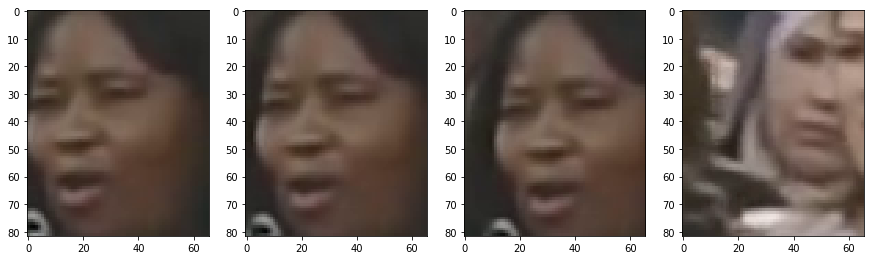

In [4]:
#Using coordinates detection of one personne over 3 consecutives frame
f,ax = plt.subplots(ncols=4, figsize=(15,15))
idx_detection = 10
# 14th detection of the first pictures
x1, y1, x2, y2 = detections[0][idx_detection]
# We use the coordinates of this detection on the two following frames
for j in range(4):
    img = pics[j][y1:y2,x1:x2,:]
    ax[j].imshow(img)
## --> It moves between frame (target + 2) and (target + 15)

In [5]:
neigh_detect, distances = detect.train_binclas(pics, detections, 10)

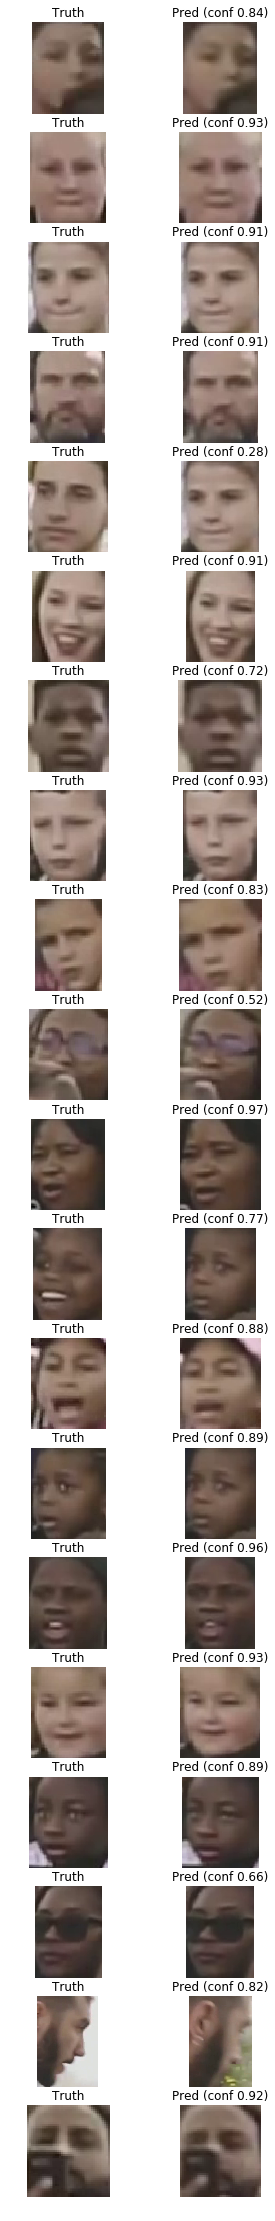

In [8]:
f, axes = plt.subplots(ncols=2, nrows=20, figsize=(5,40))
for p in range(20):
    neigh_detect, distances = detect.train_binclas(pics, detections, p)
    idx_max = np.argmax(distances[:,1])
    val_max = np.max(distances[:,1])
    x1_, y1_, x2_, y2_ = neigh_detect[idx_max]
    x1, y1, x2, y2 = detections[0][p]
    img_truth = pics[0][y1:y2,x1:x2,:]
    img_pred = pics[3][y1_:y2_,x1_:x2_,:]
    axes[p,0].imshow(img_truth)
    axes[p,1].imshow(img_pred)
    axes[p,1].axis('off')
    axes[p,0].axis('off')
    axes[p,0].set_title('Truth')
    axes[p,1].set_title('Pred (conf %.2f)' % val_max)

### One classifier for all faces from frame 0

In [189]:
imp.reload(detect)
df = pd.DataFrame()
for idx in range(20):
    df = pd.concat([df, detect.create_positive_set(pics, detections[0][idx], idx)])
df = df.sample(len(df)).reset_index(drop=True)
# Train sets
y = df[128]
X = df.drop(128, axis=1)
# training
clf = SVC(C=1, kernel='linear', probability=True)
_= clf.fit(X, y)

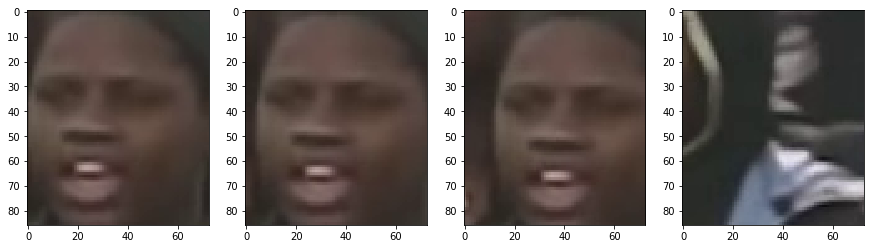

In [183]:
#Using coordinates detection of one personne over 3 consecutives frame
f,ax = plt.subplots(ncols=4, figsize=(15,15))
idx_detection = 14
# 14th detection of the first pictures
x1, y1, x2, y2 = detections[0][idx_detection]
# We use the coordinates of this detection on the two following frames
for j in range(4):
    img = pics[j][y1:y2,x1:x2,:]
    ax[j].imshow(img)
## --> She moves between frame (target + 2) and (target + 15)

In [190]:
# keeping 4th picture detections in the neighborhoud
neigh_detect = [k for k in detections[3] if 
                np.abs(k[0]-x1) < 600 and 
                np.abs(k[1]-y1) < 600 and
                np.abs(k[2]-x2) < 600 and
                np.abs(k[3]-y2) < 600]

# Get face images to classify
img_neighb = [pics[3][y1_:y2_,x1_:x2_,:] for (x1_, y1_, x2_, y2_) in detections[3]]
# Encode each face
neigh_detect_encodings = detect.encoding_faces(img_neighb, -1, neigh_detect)[:,:128]
# compute distances
distances = clf.predict_proba(neigh_detect_encodings)

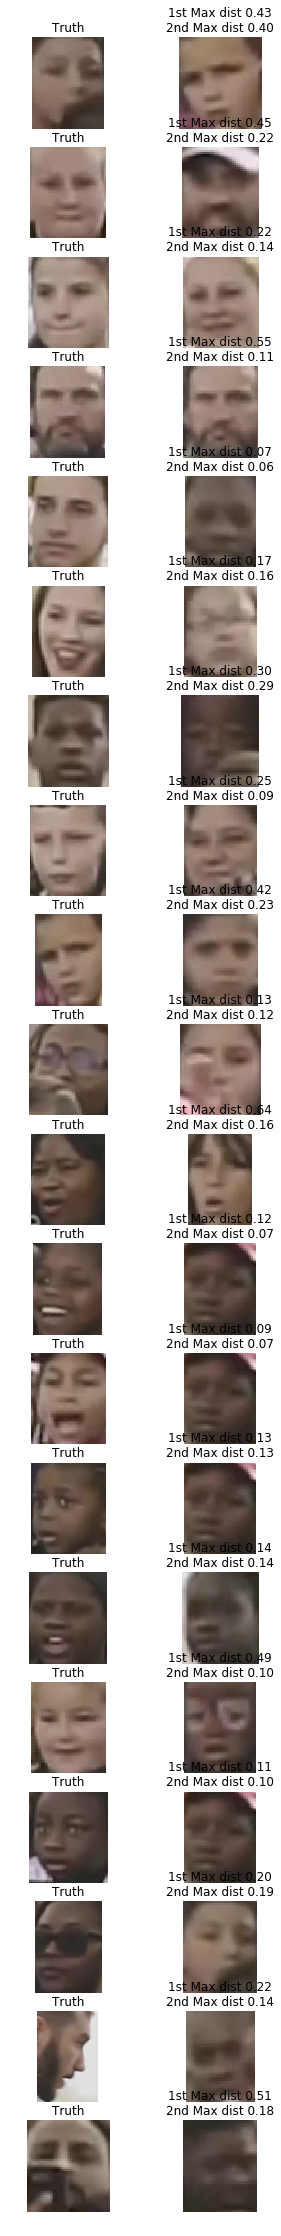

In [191]:
f, axes = plt.subplots(ncols=2, nrows=20, figsize=(5,40))
for p in range(20):
    idx_max = np.argmax(distances[:, p])
    val_max = sorted(distances[:, p], reverse=True)[:2]
    x1_, y1_, x2_, y2_ = neigh_detect[idx_max]
    x1, y1, x2, y2 = detections[0][p]
    img_truth = pics[0][y1:y2,x1:x2,:]
    img_pred = pics[3][y1_:y2_,x1_:x2_,:]
    axes[p,0].imshow(img_truth)
    axes[p,1].imshow(img_pred)
    axes[p,1].axis('off')
    axes[p,0].axis('off')
    axes[p,0].set_title('Truth')
    axes[p,1].set_title('1st Max dist %.2f\n2nd Max dist %.2f' % (val_max[0], val_max[1]))